In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import xarray as xr
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from tqdm import tqdm
import string
from matplotlib.ticker import MultipleLocator

import LMRt

## Load data

In [2]:
exp_dict = {
    'LMR (Corals+Li13b6)': '../recons/recon_Corals_Li13b6.nc',
}

In [3]:
nino34 = {}
year = {}
for exp_tag, path in exp_dict.items():
    with xr.open_dataset(path) as ds:
        nino34[exp_tag] = ds['nino34'].values
        year[exp_tag] = ds['year'].values
        print(np.shape(nino34[exp_tag]))

(5, 901)


In [4]:
df = pd.read_table('../data/enso-li2013.txt', skiprows=125)
nino34['Li13'] = df['sst.anom'].values
year['Li13'] = df['age_AD'].values

## Eruption years

In [5]:
events = {}
nonevents = {}

In [6]:
# SI Table 3 of Toohey et al. (2019): https://doi.org/10.1038/s41561-018-0286-2 + eVolv2k v3 (VSSI>6)
vssi = {
    1107: 19.16,
    1170: 18.05,
    1182: 10.05,
    1191: 8.53,
    1229: 23.78,
    1257: 59.42,
    1275: 11.53,
    1286: 15.06,
    1343: 15.11,
    1452: 9.97,
    1458: 32.98,
    1586: 8.51,
    1594: 8.87,
    1600: 18.95,
    1640: 18.68,
    1695: 15.74,
    1783: 20.81,
    1809: 19.26,
    1815: 28.08,
    1835: 9.48,
    1883: 9.34,
    1991: 8.50,
}
eruption_yrs = sorted(list(vssi.keys()))
print(len(eruption_yrs), eruption_yrs)

22 [1107, 1170, 1182, 1191, 1229, 1257, 1275, 1286, 1343, 1452, 1458, 1586, 1594, 1600, 1640, 1695, 1783, 1809, 1815, 1835, 1883, 1991]


In [7]:
events['VSSI>6 (1100-2000)'] = eruption_yrs
events['VSSI>6 (1100-2000)'] = np.array(sorted(events['VSSI>6 (1100-2000)']))


start_yr, end_yr = events['VSSI>6 (1100-2000)'][0], events['VSSI>6 (1100-2000)'][-1]
preyr, postyr = 3, 6
nonevents['VSSI>6 (1100-2000)'] = list(np.arange(start_yr-preyr, end_yr+postyr+1))
events_expanded = set()
years = np.arange(1, 2001)
for e in events['VSSI>6 (1100-2000)']:
    idx = list(years).index(e)
    subset = set(years[idx:idx+postyr+1])
    events_expanded |= subset
for e in events_expanded:
    nonevents['VSSI>6 (1100-2000)'].remove(e)
    
nonevents['VSSI>6 (1100-2000)'] = np.array(nonevents['VSSI>6 (1100-2000)'])
    
print(len(events['VSSI>6 (1100-2000)']), events['VSSI>6 (1100-2000)'])
print(len(nonevents['VSSI>6 (1100-2000)']), nonevents['VSSI>6 (1100-2000)'])

22 [1107 1170 1182 1191 1229 1257 1275 1286 1343 1452 1458 1586 1594 1600
 1640 1695 1783 1809 1815 1835 1883 1991]
743 [1104 1105 1106 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124
 1125 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138
 1139 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152
 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166
 1167 1168 1169 1177 1178 1179 1180 1181 1189 1190 1198 1199 1200 1201
 1202 1203 1204 1205 1206 1207 1208 1209 1210 1211 1212 1213 1214 1215
 1216 1217 1218 1219 1220 1221 1222 1223 1224 1225 1226 1227 1228 1236
 1237 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249 1250
 1251 1252 1253 1254 1255 1256 1264 1265 1266 1267 1268 1269 1270 1271
 1272 1273 1274 1282 1283 1284 1285 1293 1294 1295 1296 1297 1298 1299
 1300 1301 1302 1303 1304 1305 1306 1307 1308 1309 1310 1311 1312 1313
 1314 1315 1316 1317 1318 1319 1320 1321 1322 1323 1324 1325 1326 1327
 1328 1329 1330 1331 1332 13

In [8]:
events['VSSI>6 (1300-2000)'] = events['VSSI>6 (1100-2000)'][events['VSSI>6 (1100-2000)']>=1300]
nonevents['VSSI>6 (1300-2000)'] = nonevents['VSSI>6 (1100-2000)'][nonevents['VSSI>6 (1100-2000)']>=1300]
# print(len(events['VSSI>6 (1300-2000)']), events['VSSI>6 (1300-2000)'])
# print(len(nonevents['VSSI>6 (1300-2000)']), nonevents['VSSI>6 (1300-2000)'])

events['VSSI>6 (1300-1850)'] = events['VSSI>6 (1100-2000)'][(events['VSSI>6 (1100-2000)']>=1300)&(events['VSSI>6 (1100-2000)']<=1850)]
nonevents['VSSI>6 (1300-1850)'] = nonevents['VSSI>6 (1100-2000)'][(nonevents['VSSI>6 (1100-2000)']>=1300) & (nonevents['VSSI>6 (1100-2000)']<=1850)]

In [9]:
events['VEI>4 (1300-2000)'] = [
    1350, 1360, 1450, 1580, 1586, 1593, 1600, 1641, 1660, 1673, 1680, 1815, 1822, 1831, 1835, 1883,
    1902, 1913, 1951, 1963, 1982, 1991
]

events['VEI>4 (1300-1850)'] = [1350, 1360, 1450, 1580, 1586, 1593, 1600, 1641, 1660, 1673, 1680, 1815, 1822, 1831, 1835]

start_yr, end_yr = 1300, 2000
preyr, postyr = 3, 6
nonevents['VEI>4 (1300-2000)'] = list(np.arange(start_yr-preyr, end_yr+postyr+1))
events_expanded = set()
years = np.arange(1, 2001)
for e in events['VEI>4 (1300-2000)']:
    idx = list(years).index(e)
    subset = set(years[idx:idx+postyr+1])
    events_expanded |= subset
for e in events_expanded:
    nonevents['VEI>4 (1300-2000)'].remove(e)
    
nonevents['VEI>4 (1300-1850)'] = nonevents['VEI>4 (1300-2000)']
    
print(len(events['VEI>4 (1300-2000)']), events['VEI>4 (1300-2000)'])
print(len(nonevents['VEI>4 (1300-2000)']), nonevents['VEI>4 (1300-2000)'])

22 [1350, 1360, 1450, 1580, 1586, 1593, 1600, 1641, 1660, 1673, 1680, 1815, 1822, 1831, 1835, 1883, 1902, 1913, 1951, 1963, 1982, 1991]
560 [1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1357, 1358, 1359, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1457, 1458, 1459, 1460, 1

## SEA

In [10]:
# SEA analysis
sea_res = {}
nboot = 1000

exp_tag = 'LMR (Corals+Li13b6)'

for events_tag in ['VSSI>6 (1100-2000)', 'VSSI>6 (1300-2000)', 'VSSI>6 (1300-1850)', 'VEI>4 (1300-2000)', 'VEI>4 (1300-1850)']:
    volc_yrs = events[events_tag]
    nonvolc_yrs = nonevents[events_tag]
        
    sea_res[f'{exp_tag}, {events_tag}'] = LMRt.utils.sea_dbl(
        year[exp_tag], nino34[exp_tag][2, :], volc_yrs, nonevents=nonvolc_yrs,
        preyr=3, postyr=6, nsample=len(volc_yrs),
        qs=[0.05, 0.5, 0.95], qs_signif=[0.01, 0.05, 0.10, 0.90, 0.95, 0.99],
        draw_mode='non-events', nboot_event=nboot, seeds=np.arange(nboot),
    )
    
exp_tag = 'Li13'

for events_tag in ['VSSI>6 (1300-2000)', 'VSSI>6 (1300-1850)', 'VEI>4 (1300-2000)', 'VEI>4 (1300-1850)']:
    volc_yrs = events[events_tag]
    nonvolc_yrs = nonevents[events_tag]
        
    sea_res[f'{exp_tag}, {events_tag}'] = LMRt.utils.sea_dbl(
        year[exp_tag], nino34[exp_tag], volc_yrs, nonevents=nonvolc_yrs,
        preyr=3, postyr=6, nsample=len(volc_yrs),
        qs=[0.05, 0.5, 0.95], qs_signif=[0.01, 0.05, 0.10, 0.90, 0.95, 0.99],
        draw_mode='non-events', nboot_event=nboot, seeds=np.arange(nboot),
    )

## Visualization

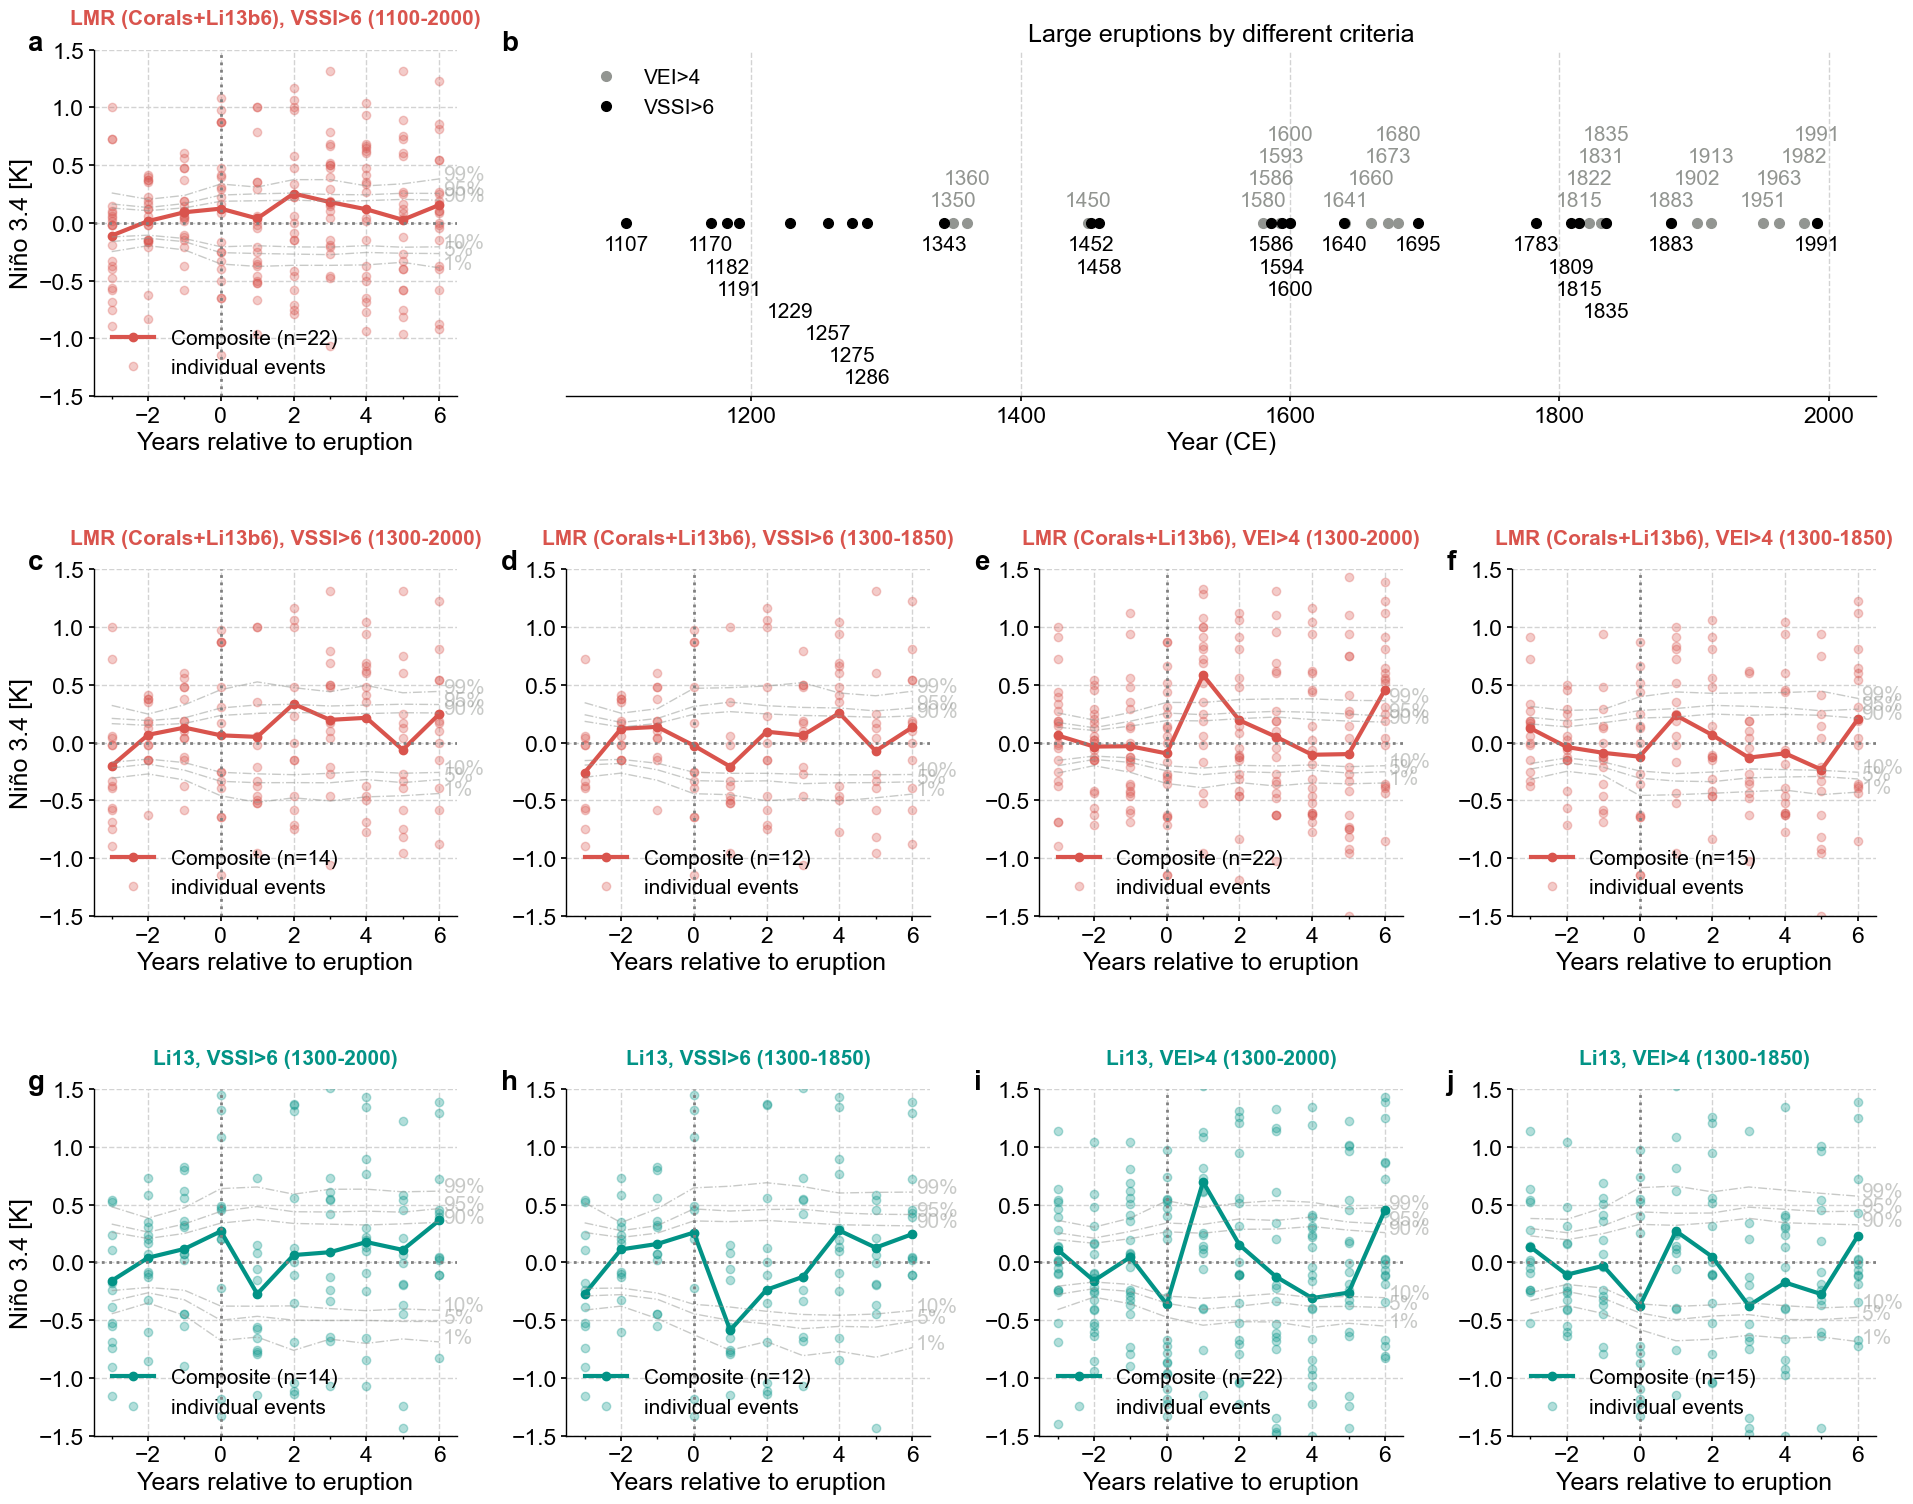

Figure saved at: "../figs/Fig-4.pdf"


In [11]:
LMRt.set_style('journal', font_scale=1.5)

exp_color = {
    'LMR (Corals+Li13b6)': sns.xkcd_rgb['pale red'],
    'Li13': sns.xkcd_rgb['teal'],
}

fig = plt.figure(figsize=[23, 18])
gs = gridspec.GridSpec(3, 4)       
gs.update(wspace=0.3, hspace=0.5)


#====================================================
# SEA
#----------------------------------------------------
ax_sea = {}

xlim = [-3.5, 6.5]
ylim = [-1.5, 1.5]
yticks = np.linspace(-1.5, 1.5, 7)
plot_mode = 'composite_norm'
fscale = 1.5
fs = 15

exp_tag = 'LMR (Corals+Li13b6)'
for i, events_tag in enumerate(['VSSI>6 (1100-2000)', 'VSSI>6 (1300-2000)', 'VSSI>6 (1300-1850)', 'VEI>4 (1300-2000)', 'VEI>4 (1300-1850)']):
    volc_yrs = events[events_tag]
    tag = f'{exp_tag}, {events_tag}'
    if events_tag == 'VSSI>6 (1100-2000)':
        ax_sea[tag] = plt.subplot(gs[0, i])
    else:
        ax_sea[tag] = plt.subplot(gs[1, i-1])

    ylb = 'Niño 3.4 [K]' if i in [0, 1] else None
    ax_sea[tag] = LMRt.visual.plot_sea_res(
        sea_res[tag], ylabel=ylb, color=exp_color[exp_tag],
        font_scale=fscale, ax=ax_sea[tag],  label=f'Composite (n={len(volc_yrs)})',
        xlim=xlim, ylim=ylim, plot_mode=plot_mode, yticks=yticks, signif_fontsize=15,
        indi_style='o', indi_alpha=0.3, xlabel='Years relative to eruption',
    )
    ax_sea[tag].set_title(tag, weight='bold', color=exp_color[exp_tag], y=1.05, fontsize=fs)
    ax_sea[tag].legend(frameon=False, loc='lower left', ncol=1, fontsize=15)
    ax_sea[tag].xaxis.set_major_locator(MultipleLocator(2))
    ax_sea[tag].xaxis.set_minor_locator(MultipleLocator(1))
    ax_sea[tag].tick_params(which='minor', length=2, width=1)
    
# eruption yrs
ms = 7
ax_yrs = plt.subplot(gs[0, 1:])
ne_Li13 = len(events['VEI>4 (1300-2000)'])
ne_LMR = len(events['VSSI>6 (1100-2000)'])
ts_Li13 = LMRt.Series(time=events['VEI>4 (1300-2000)'], value=[0 for i in range(ne_Li13)])
ts_LMR = LMRt.Series(time=events['VSSI>6 (1100-2000)'], value=[0 for i in range(ne_LMR)])

clr_VEI = sns.xkcd_rgb['grey']
clr_VSSI = sns.xkcd_rgb['black']
ts_Li13.plot(ax=ax_yrs, mute=True, marker='o', linestyle='', markersize=ms, label='VEI>4', color=clr_VEI)
ts_LMR.plot(ax=ax_yrs, marker='o', linestyle='', markersize=ms, label='VSSI>6', color=clr_VSSI)

bs = 0.007
yr_last = 1000
y_coord = bs
for yr in events['VEI>4 (1300-2000)']:
    if yr-yr_last < 20:
        y_coord += bs
    else:
        y_coord = bs
    yr_last = yr
        
    ax_yrs.text(yr, y_coord, yr, color=clr_VEI, fontsize=fs, horizontalalignment='center', verticalalignment='center')
    
yr_last = 1000
y_coord = -bs
for yr in events['VSSI>6 (1100-2000)']:
    if yr-yr_last < 40:
        y_coord -= bs
    else:
        y_coord = -bs
    yr_last = yr
        
    ax_yrs.text(yr, y_coord, yr, color=clr_VSSI, fontsize=fs, horizontalalignment='center', verticalalignment='center')
    
ax_yrs.legend(loc='upper left', fontsize=fs)
ax_yrs.set_xlabel('Year (CE)')
ax_yrs.yaxis.set_visible(False)
ax_yrs.spines.left.set_visible(False)
ax_yrs.set_title('Large eruptions by different criteria')
    
    
exp_tag = 'Li13'
for i, events_tag in enumerate(['VSSI>6 (1300-2000)', 'VSSI>6 (1300-1850)', 'VEI>4 (1300-2000)', 'VEI>4 (1300-1850)']):
    volc_yrs = events[events_tag]
    tag = f'{exp_tag}, {events_tag}'
    ax_sea[tag] = plt.subplot(gs[2, i])

    ylb = 'Niño 3.4 [K]' if i == 0 else None
    ax_sea[tag] = LMRt.visual.plot_sea_res(
        sea_res[tag], ylabel=ylb, color=exp_color[exp_tag],
        font_scale=fscale, ax=ax_sea[tag],  label=f'Composite (n={len(volc_yrs)})',
        xlim=xlim, ylim=ylim, plot_mode=plot_mode, yticks=yticks, signif_fontsize=15,
        indi_style='o', indi_alpha=0.3, xlabel='Years relative to eruption',
    )
    ax_sea[tag].set_title(tag, weight='bold', color=exp_color[exp_tag], y=1.05, fontsize=fs)
    ax_sea[tag].legend(frameon=False, loc='lower left', ncol=1, fontsize=15)
    
    ax_sea[tag].xaxis.set_major_locator(MultipleLocator(2))
    ax_sea[tag].xaxis.set_minor_locator(MultipleLocator(1))
    ax_sea[tag].tick_params(which='minor', length=2, width=1)
    
#====================================================
fs = 20
tag = list(ax_sea.keys())[0]
ax_sea[tag].text(
    -0.18, 1., string.ascii_lowercase[0],
    transform=ax_sea[tag].transAxes, 
    size=fs, weight='bold',
)
ax_yrs.text(
    -0.05, 1., string.ascii_lowercase[1],
    transform=ax_yrs.transAxes, 
    size=fs, weight='bold',
)
    
for i, tag in enumerate(list(ax_sea.keys())[1:]):
    ax_sea[tag].text(
        -0.18, 1., string.ascii_lowercase[i+2],
        transform=ax_sea[tag].transAxes, 
        size=fs, weight='bold',
    )
    
    
LMRt.showfig(fig)
LMRt.savefig(fig, '../figs/Fig-4.pdf')